In [1]:
USE_YAM = True
if not USE_YAM:
    DID = ''
else:
    DID = 'y'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
import numpy as np

from Bio import SeqUtils
from Bio.Seq import Seq
from Bio import motifs
import random
random.seed(2021)

In [3]:
if not USE_YAM:
    utr_seq = pd.read_csv('../processed_data/utrs.csv', header = 0)
    utr_seq = utr_seq.loc[:,['Gene Name', 'foreign']]
    utr_seq.rename(columns = {'Gene Name':'gene', 'foreign':'utr_seq'}, inplace = True)
    utr_seq = utr_seq.loc[utr_seq.utr_seq.notna()]
    utr_seq = utr_seq.loc[utr_seq.gene.notna()]
    utr_seq
    genes_fi = pd.read_csv('../processed_data/fluorescence_dataset.csv')
    genes_fi.dropna(subset=['intensity'],inplace=True)
    genes_fi = genes_fi.loc[genes_fi.intensity.notna()]
    genes_fi = genes_fi.loc[genes_fi.intensity > 0]
    # genes_fi.intensity, _ = stats.boxcox(genes_fi.intensity)
    fi_trans = [math.log(fi) for fi in genes_fi.intensity]
    genes_fi.intensity = fi_trans
    genes_fi = genes_fi.loc[genes_fi.intensity > -20]
    genes_fi
    df = pd.merge(genes_fi, utr_seq, on = 'gene')
    df = df.loc[df.intensity.notna()]
    df.drop_duplicates(inplace = True)
else:
    utr_seq = pd.read_csv('../processed_data/yamanishi_data.csv', header = 0)
    utr_seq = utr_seq.loc[utr_seq.utr_seq.notna()]
    utr_seq = utr_seq.loc[utr_seq.gene.notna()]
    utr_seq
    df = utr_seq
    df = df.loc[df.intensity.notna()]
    df.drop_duplicates(inplace = True)

In [4]:
df['utr_seq'].apply(lambda x: len(x)).min()

400

<AxesSubplot:>

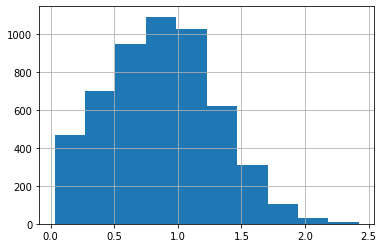

In [5]:
df.intensity.hist()

In [6]:
df = df.loc[df.intensity.notna()]
df.drop_duplicates(inplace = True)

In [7]:
df['int_group'] = np.digitize(df['intensity'].values, df['intensity'].quantile(np.arange(0,1,0.1)).values) - 1
df['int_group'] = df.int_group.astype('category')

In [8]:
df.groupby('int_group').gene.count()

int_group
0    531
1    530
2    530
3    530
4    530
5    530
6    530
7    530
8    530
9    531
Name: gene, dtype: int64

### Sequence features extraction

In [9]:
# Length of the sequence
df['len_seq'] = [len(i) for i in df.loc[:,'utr_seq']]
df['len_seq_log'] = [math.log2(len(i)) for i in df.loc[:,'utr_seq']]

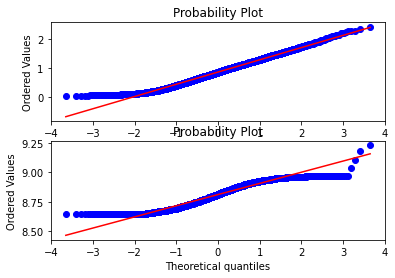

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(df.intensity, dist=stats.norm, plot=ax1)

ax2 = fig.add_subplot(212)
prob = stats.probplot(df.len_seq_log, dist=stats.norm, plot=ax2)


In [11]:
# AT/GC ratio
df['at_gc'] = [(i.count('A')+i.count('T'))/(i.count('G')+i.count('C')) for i in df.loc[:,'utr_seq']]

In [12]:
# Percent GC
df['pct_gc'] = [SeqUtils.GC(i) for i in df.loc[:,'utr_seq']]

In [13]:
# Molecular weight
df['molecular_w'] = [SeqUtils.molecular_weight(i) for i in df.loc[:,'utr_seq']]

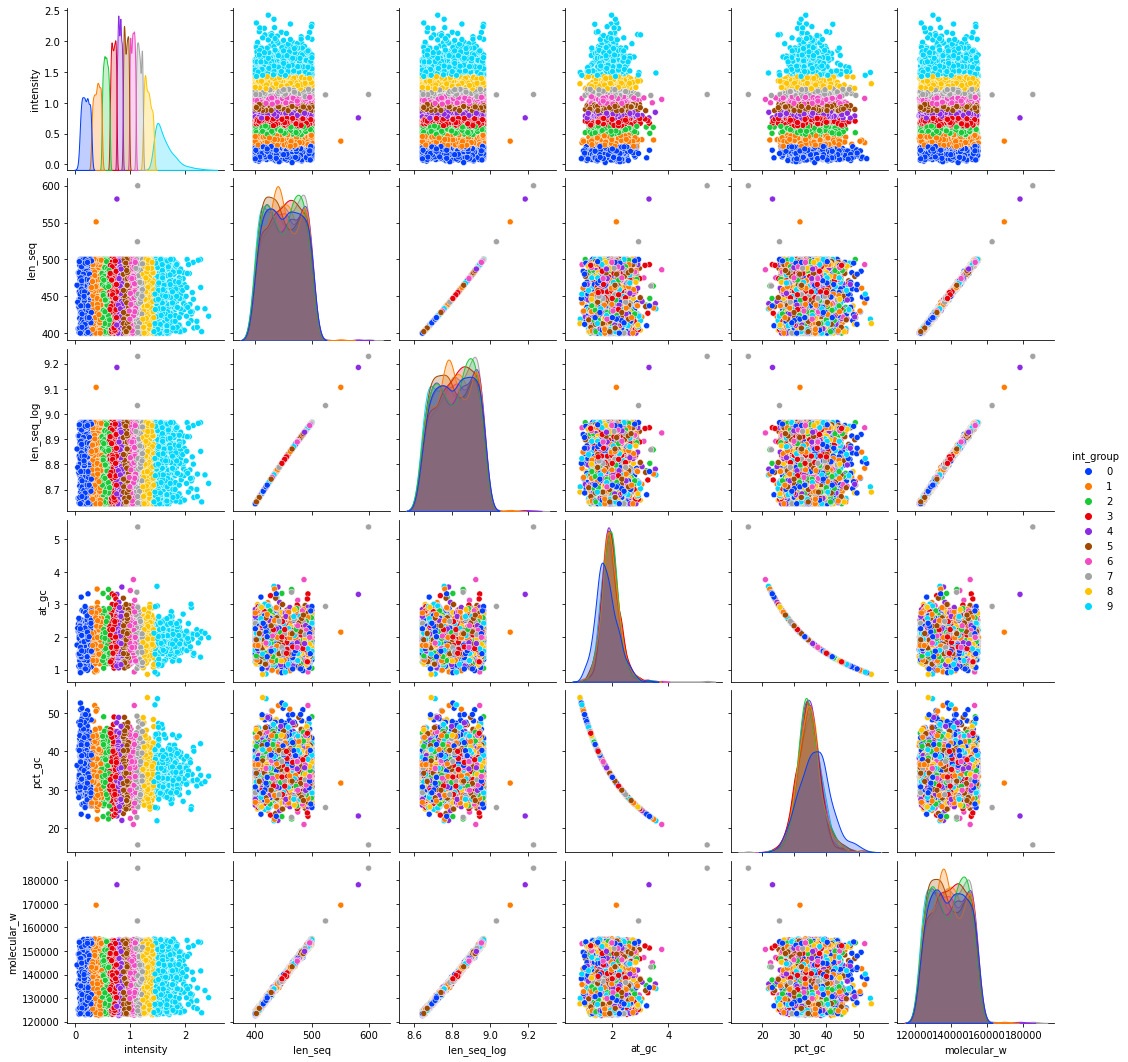

In [14]:
sns.pairplot(df, hue = 'int_group', palette = sns.color_palette('bright', 10))

In [15]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### Per group motif discovery (TBC)

[Gibbs Sampling](https://open.oregonstate.education/appliedbioinformatics/chapter/chapter-2-sequence-motifs/).

In [16]:
df.head()

gene  intensity                                            utr_seq  \
0   AI1   0.405669  TTAATGATACTCAATATGGAAAGCCGTATGATGGGAAACTATCACG...   
1   AI2   1.129300  TATTAAATATGCGTTAAATGGAGAGCCGTATGATATGAAAGTATCA...   
2   AI3   0.760753  AATTATTATTACTTTCTTCCCCTCCGAATCCGTAATATATTTACGG...   
3  TFC3   1.281130  ACATAATGAAATGAGGTGTATAAATTTTACTTTTATGTAACCAAAG...   
4  VPS8   1.203350  TTTAATACAACTTTGGTTACATAAAAGTAAAATTTATACACCTCAT...   

  int_group  len_seq  len_seq_log     at_gc     pct_gc  molecular_w  
0         1      460     8.845490  1.658960  37.608696  142350.9735  
1         7      524     9.033423  2.939850  25.381679  162779.5699  
2         4      440     8.781360  2.098592  32.272727  136104.3051  
3         8      498     8.960002  1.797753  35.742972  153882.4676  
4         7      461     8.848623  1.881250  34.707158  142086.9576

In [17]:
import os
import csv
os.makedirs('meme_input', exist_ok=True)
def write_file(x):
    p = x['utr_seq'].apply(
        lambda y: f'>{id(y)}\n' + y)
    with open(f"meme_input/{x['int_group'].unique()[0]}.fasta", 'w') as out:
        out.write('\n'.join(p.values))
df.groupby('int_group').apply(write_file)

Empty DataFrame
Columns: []
Index: []

In [18]:
def write_inv_file(x, i):
    p = x['utr_seq'].apply(
        lambda y: f'>{id(y)}\n' + y)
    with open(f"meme_input/{i}inv.fasta", 'w') as out:
        out.write('\n'.join(p.values))
for cnt in range(10):
    write_inv_file(df[df['int_group'] != cnt], cnt)

In [19]:
from Bio.motifs import parse

In [20]:
os.environ['PATH'] += os.pathsep + '/home/vaslem/meme/bin:/home/vaslem/meme/libexec/meme-5.4.1'

In [21]:
import pickle
from tqdm.notebook import tqdm

### Trying to find motifs using MEME
- in FI decile group i using background sequences not belonging in i
- in 10th FI decile group using background sequences those in 1st

In [79]:
MINW = 5
MAXW = 10
NMOTIFS = 20
motifs = []
motifs_s = {}
try:
    with open(f'meme_output/{MINW}_{MAXW}_{NMOTIFS}_10{DID}.pkl', 'rb') as inp:
        motifs_s, motifs = pickle.load(inp)
except IOError:
    for cnt in tqdm(range(10)):
        os.system(
            f'meme meme_input/{cnt}{DID}.fasta  -p 8 -objfun de -minw {MINW}'
            f' -maxw {MAXW} -nmotifs {NMOTIFS} -evt 0.01 -oc meme_output/{cnt}{DID}  -dna -neg meme_input/{cnt}{DID}inv.fasta')
        with open(f"meme_output/{cnt}{DID}/meme.txt") as f:
            i_motifs = parse(f, 'MINIMAL')
            motifs_s[cnt] = [str(m.degenerate_consensus) for m in i_motifs]
            motifs.extend(i_motifs)
    os.system(
            f'meme meme_input/9{DID}.fasta  -p 8 -objfun de -minw {MINW}'
            f' -maxw {MAXW} -nmotifs {NMOTIFS} -evt 0.01 -oc meme_output/ex{DID} -dna -neg meme_input/0{DID}.fasta')
    with open(f"meme_output/ex{DID}/meme.txt") as f:
        i_motifs = parse(f, 'MINIMAL')
        motifs_s[10] = [str(m.degenerate_consensus) for m in i_motifs]
        motifs.extend(i_motifs)
    with open(f'meme_output/{MINW}_{MAXW}_{NMOTIFS}_10{DID}.pkl', 'wb') as out:
        pickle.dump((motifs_s, motifs), out)

In [80]:
motifs_s

{0: ['AAAAA', 'TTTTTT', 'AAAAAAA'],
 1: [],
 2: ['TTTTT', 'TCTTC'],
 3: [],
 4: ['TTTTC', 'TCTTT', 'GSAGG', 'TCTTC', 'TTTTG', 'AAGAAAA'],
 5: ['TTTTC',
  'GGCGC',
  'CCTCT',
  'GCCGG',
  'TTTTT',
  'TCCTTC',
  'GGCGG',
  'GCCGC',
  'TTCTT',
  'GCCATTG'],
 6: ['AAAAA', 'GAAAAG'],
 7: ['AAAAA', 'GGAAG', 'CACCA', 'GGAAAAG'],
 8: [],
 9: ['AAAAA', 'GAAGG', 'AGARAA', 'GGCDG'],
 10: ['AAARAAA', 'TATATA', 'GAAGAA', 'GGAAA', 'GAAAAA']}

In [24]:
seqs = [Seq(x) for x in df['utr_seq']]

In [25]:
from tqdm.notebook import tqdm

In [26]:
def create_features(seqs, motifs):
    scores = np.zeros([len(seqs), len(motifs)])
    counts = np.zeros([len(seqs), len(motifs)])
    for s_c, seq in tqdm(enumerate(seqs)):
        for m_c, motif in enumerate(motifs):
            counts[s_c, m_c] = 0
            if len(seq) < len(motif):
                continue
            weights = motif.pssm
            sc = weights.calculate(seq)
            
            counts[s_c, m_c] = np.sum(sc > 0)
            if not counts[s_c, m_c]:
                continue
            scores[s_c, m_c] = np.median(sc[sc>0])
                
    return counts, scores
    
            
counts, scores = create_features(seqs, motifs)

In [27]:
columns = [str(m.degenerate_consensus) for m in motifs]
columns_scores = [c + '_' + '_score' for c in columns]
columns_tfidf = [c + '_tfidf' for c in columns]
raw_columns_scores = columns_scores
columns_scores = list(set(columns_scores))
raw_columns_tfidf = columns_tfidf
columns_tfidf = list(set(columns_tfidf))
raw_columns = raw_columns_scores + raw_columns_tfidf
columns = list(set(raw_columns))

In [28]:
counts

array([[ 0.,  0.,  0., ...,  0.,  3.,  0.],
       [ 8.,  0.,  2., ...,  0.,  1.,  0.],
       [ 1.,  0.,  0., ...,  0.,  2.,  0.],
       ...,
       [ 1.,  1.,  0., ...,  0.,  1.,  1.],
       [ 3., 11.,  0., ...,  3.,  2.,  1.],
       [ 7.,  3.,  0., ...,  0.,  0.,  2.]])

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer().fit_transform(counts)
tfidf = tfidf.todense()

In [30]:
featDf = pd.DataFrame(np.hstack([scores, tfidf]), columns=raw_columns)
featDf = featDf.loc[:,~featDf.columns.duplicated()]

In [31]:
featDf.fillna(0, inplace=True)

In [32]:
featDf['intensity'] = df['intensity']
featDf['int_group'] = df['int_group']

Checking for significant difference in FI between genes with and without efficiency element.

In [33]:
p_vals = []
for e in columns:
    grp0 = featDf.loc[featDf[e] == 0].intensity
    grp1 = featDf.loc[featDf[e] != 0].intensity
    f_val, p_val = stats.ttest_ind(grp0, grp1)            
    print(f"({e} size0 = {len(grp0)}, size1 = {len(grp1)}) One-way ANOVA P ={p_val}")
    p_vals.append(p_val)

(GCCGG__score size0 = 4894, size1 = 408) One-way ANOVA P =0.8845533330054753
(AAGAAAA__score size0 = 3858, size1 = 1444) One-way ANOVA P =0.002273233134656619
(AGARAA__score size0 = 1925, size1 = 3377) One-way ANOVA P =0.0002505588260183872
(GCCATTG_tfidf size0 = 5140, size1 = 162) One-way ANOVA P =0.9248111868618282
(TTTTTT_tfidf size0 = 2037, size1 = 3265) One-way ANOVA P =0.07061648942748339
(GGAAG__score size0 = 3611, size1 = 1691) One-way ANOVA P =0.05818221257220229
(GGCDG__score size0 = 3324, size1 = 1978) One-way ANOVA P =0.9730485311783166
(GSAGG__score size0 = 3792, size1 = 1510) One-way ANOVA P =0.0009638424106578352
(TCCTTC_tfidf size0 = 4432, size1 = 870) One-way ANOVA P =0.5163795767372036
(GAAAAA__score size0 = 2718, size1 = 2584) One-way ANOVA P =0.0013674002909796871
(GAAAAA_tfidf size0 = 2718, size1 = 2584) One-way ANOVA P =0.0013674002909796871
(AAARAAA_tfidf size0 = 2715, size1 = 2587) One-way ANOVA P =0.0004960909224434526
(GGAAA_tfidf size0 = 2556, size1 = 2746) O

In [34]:
from statsmodels.stats.multitest import fdrcorrection
q_vals = fdrcorrection(p_vals)[1]

In [35]:
ordering = np.argsort(q_vals)
np.array(columns)[ordering]

array(['TATATA_tfidf', 'TATATA__score', 'AGARAA_tfidf', 'AAAAA__score',
       'AAAAA_tfidf', 'AGARAA__score', 'AAARAAA_tfidf', 'AAARAAA__score',
       'GSAGG__score', 'GSAGG_tfidf', 'GAAAAA__score', 'GAAAAA_tfidf',
       'TTTTT__score', 'TTTTT_tfidf', 'AAGAAAA_tfidf', 'AAGAAAA__score',
       'GGCGC__score', 'GGCGC_tfidf', 'AAAAAAA_tfidf', 'AAAAAAA__score',
       'GAAGAA_tfidf', 'GAAGAA__score', 'TCTTT_tfidf', 'TCTTT__score',
       'TTCTT_tfidf', 'TTCTT__score', 'GGAAA_tfidf', 'GGAAA__score',
       'CCTCT__score', 'GGAAG__score', 'CCTCT_tfidf', 'GGAAG_tfidf',
       'TTTTTT_tfidf', 'TTTTTT__score', 'TCTTC__score', 'TCTTC_tfidf',
       'CACCA_tfidf', 'CACCA__score', 'TTTTG__score', 'TTTTG_tfidf',
       'GAAGG__score', 'GAAGG_tfidf', 'TTTTC_tfidf', 'TCCTTC_tfidf',
       'TCCTTC__score', 'GCCGC_tfidf', 'GCCGC__score', 'TTTTC__score',
       'GGCGG__score', 'GGAAAAG__score', 'GGCGG_tfidf', 'GGAAAAG_tfidf',
       'GAAAAG_tfidf', 'GAAAAG__score', 'GCCGG_tfidf', 'GCCGG__score',
    

In [36]:
sig_mots = np.array(columns)[q_vals < 0.05]

In [37]:
len(sig_mots)

24

In [38]:
sig_mots

array(['AAGAAAA__score', 'AGARAA__score', 'GSAGG__score', 'GAAAAA__score',
       'GAAAAA_tfidf', 'AAARAAA_tfidf', 'AAAAAAA__score', 'GAAGAA__score',
       'AAARAAA__score', 'GSAGG_tfidf', 'GAAGAA_tfidf', 'TATATA__score',
       'TATATA_tfidf', 'AAGAAAA_tfidf', 'AAAAA__score', 'TTTTT_tfidf',
       'GGCGC_tfidf', 'AAAAAAA_tfidf', 'TTTTT__score', 'TCTTT__score',
       'AGARAA_tfidf', 'TCTTT_tfidf', 'GGCGC__score', 'AAAAA_tfidf'],
      dtype='<U14')

In [39]:
featDf['int_group'] = featDf['int_group'].astype(float)

In [40]:
# sns.pairplot(df[sig_mots.tolist() + ['int_group']], hue = 'int_group', palette = sns.color_palette('bright', 10))

### PCA

In [41]:
import plotly
from plotly import version
print (version)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

<module 'plotly.version' from '/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/plotly/version.py'>


In [42]:
from sklearn.decomposition import PCA
import plotly.express as px

In [43]:
features = columns_tfidf + columns_scores

In [44]:
df_temp = featDf[features]
# df_temp = df_6mers_test.loc[:, (df_6mers.columns != 'gene') & (df_6mers.columns != 'intensity')]
df_temp = (df_temp-df_temp.mean())/df_temp.std()
# df_temp = (df_temp-df_temp.min())/(df_temp.max()-df_temp.min())
df_temp

GCCATTG_tfidf  TTTTTT_tfidf  TCCTTC_tfidf  GAAAAA_tfidf  AAARAAA_tfidf  \
0         -0.160031     -0.907424      5.211198     -0.804234      -0.778620   
1         -0.160031     -0.907424     -0.384796     -0.804234       0.484302   
2         -0.160031     -0.907424     -0.384796     -0.804234      -0.778620   
3         -0.160031      0.409295     -0.384796      1.012095      -0.778620   
4         -0.160031     -0.907424     -0.384796     -0.804234      -0.778620   
...             ...           ...           ...           ...            ...   
5297      -0.160031      1.363444     -0.384796     -0.804234      -0.778620   
5298      -0.160031     -0.907424     -0.384796     -0.804234      -0.778620   
5299      -0.160031     -0.277900     -0.384796      0.932541      -0.778620   
5300      -0.160031      2.020179     -0.384796     -0.069972      -0.778620   
5301      -0.160031      0.291821     -0.384796      1.401475      -0.778620   

      GGAAA_tfidf  CCTCT_tfidf  GCCGC_tfidf  GSAGG_tfidf  TTCTT_tfidf  ...  \
0        7.405226    -0.556388    -0.309166    -0.512016    -1.119851  ...   
1        0.071625    -0.556388    -0.309166     0.609504    -1.119851  ...   
2        3.826644    -0.556388    -0.309166     2.570103     0.303600  ...   
3       -0.763506     1.293976    -0.309166    -0.512016    -1.119851  ...   
4       -0.763506    -0.556388    -0.309166    -0.512016    -1.119851  ...   
...           ...          ...          ...          ...          ...  ...   
5297    -0.763506    -0.556388    -0.309166    -0.512016    -0.138105  ...   
5298    -0.763506    -0.556388    -0.309166    -0.512016    -1.119851  ...   
5299     0.552915    -0.556388    -0.309166    -0.512016     2.962501  ...   
5300     0.349589    -0.556388    -0.309166     0.235387    -0.429487  ...   
5301    -0.763506    -0.556388    -0.309166    -0.512016    -1.119851  ...   

      TCTTC__score  GAAGG__score  TTTTT__score  TTTTC__score  TCTTT__score  \
0        -1.188245     -0.651771      0.379963      0.432309      0.543731   
1         0.841418      1.533991     -2.631341     -2.312724      0.543731   
2         0.841418      1.533991     -2.631341     -2.312724     -1.838799   
3        -1.188245     -0.651771      0.379963      0.432309      0.543731   
4        -1.188245     -0.651771     -2.631341     -2.312724      0.543731   
...            ...           ...           ...           ...           ...   
5297      0.841418     -0.651771      0.379963      0.432309      0.543731   
5298     -1.188245     -0.651771     -2.631341      0.432309      0.543731   
5299      0.841418      1.533991      0.379963      0.432309      0.543731   
5300     -1.188245      1.533991      0.379963      0.432309      0.543731   
5301     -1.188245      1.533991      0.379963      0.432309      0.543731   

      GGCGC__score  GGAAA__score  GGCGG__score  TTTTG__score  GGAAAAG__score  
0        -0.334976      0.964693     -0.354831      0.580635       -0.261328  
1        -0.334976      0.964693     -0.354831      0.580635        3.825880  
2        -0.334976      0.964693     -0.354831     -1.721928       -0.261328  
3         2.984728     -1.036404     -0.354831      0.580635       -0.261328  
4        -0.334976     -1.036404     -0.354831      0.580635       -0.261328  
...            ...           ...           ...           ...             ...  
5297      2.984728     -1.036404     -0.354831      0.580635       -0.261328  
5298     -0.334976     -1.036404     -0.354831     -1.721928       -0.261328  
5299     -0.334976      0.964693     -0.354831     -1.721928       -0.261328  
5300     -0.334976      0.964693      2.817708      0.580635       -0.261328  
5301     -0.334976     -1.036404     -0.354831      0.580635       -0.261328  

[5302 rows x 60 columns]

In [45]:
%matplotlib inline

In [46]:
pca = PCA(n_components = 7)
components = pca.fit_transform(df_temp)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(7),
    color=df.int_group,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [47]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

x = 0
y = 1

fig = px.scatter(components, x=x, y=y, color=df.int_group)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, x],
        y1=loadings[i, y]
    )
    fig.add_annotation(
        x=loadings[i, x],
        y=loadings[i, y],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [48]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

### Classification (RF)

[Source](https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/)

In [49]:

# df_temp = pd.DataFrame(components)
df_temp = featDf.loc[:, features]

# df_temp = (df_temp-df_temp.mean())/df_temp.std()
df_temp

GCCATTG_tfidf  TTTTTT_tfidf  TCCTTC_tfidf  GAAAAA_tfidf  AAARAAA_tfidf  \
0               0.0      0.000000      0.410598      0.000000       0.000000   
1               0.0      0.000000      0.000000      0.000000       0.154131   
2               0.0      0.000000      0.000000      0.000000       0.000000   
3               0.0      0.219661      0.000000      0.127129       0.000000   
4               0.0      0.000000      0.000000      0.000000       0.000000   
...             ...           ...           ...           ...            ...   
5297            0.0      0.378836      0.000000      0.000000       0.000000   
5298            0.0      0.000000      0.000000      0.000000       0.000000   
5299            0.0      0.105020      0.000000      0.121560       0.000000   
5300            0.0      0.488396      0.000000      0.051393       0.000000   
5301            0.0      0.200063      0.000000      0.154382       0.000000   

      GGAAA_tfidf  CCTCT_tfidf  GCCGC_tfidf  GSAGG_tfidf  TTCTT_tfidf  ...  \
0        0.727634     0.000000          0.0     0.000000     0.000000  ...   
1        0.074390     0.000000          0.0     0.101212     0.000000  ...   
2        0.408870     0.000000          0.0     0.278148     0.152724  ...   
3        0.000000     0.158218          0.0     0.000000     0.000000  ...   
4        0.000000     0.000000          0.0     0.000000     0.000000  ...   
...           ...          ...          ...          ...          ...  ...   
5297     0.000000     0.000000          0.0     0.000000     0.105333  ...   
5298     0.000000     0.000000          0.0     0.000000     0.000000  ...   
5299     0.117261     0.000000          0.0     0.000000     0.438002  ...   
5300     0.099150     0.000000          0.0     0.067450     0.074070  ...   
5301     0.000000     0.000000          0.0     0.000000     0.000000  ...   

      TCTTC__score  GAAGG__score  TTTTT__score  TTTTC__score  TCTTT__score  \
0         0.000000      0.000000      7.975484      8.878566      8.878566   
1         9.717168     11.090427      0.000000      0.000000      8.878566   
2         9.717168     11.090427      0.000000      0.000000      0.000000   
3         0.000000      0.000000      7.975484      8.878566      8.878566   
4         0.000000      0.000000      0.000000      0.000000      8.878566   
...            ...           ...           ...           ...           ...   
5297      9.717168      0.000000      7.975484      8.878566      8.878566   
5298      0.000000      0.000000      0.000000      8.878566      8.878566   
5299      9.717168     11.090427      7.975484      8.878566      8.878566   
5300      0.000000     11.090427      7.975484      8.878566      8.878566   
5301      0.000000     11.090427      7.975484      8.878566      8.878566   

      GGCGC__score  GGAAA__score  GGCGG__score  TTTTG__score  GGAAAAG__score  
0         0.000000     10.201974      0.000000      8.962467        0.000000  
1         0.000000     10.201974      0.000000      8.962467       14.339726  
2         0.000000     10.201974      0.000000      0.000000        0.000000  
3        12.717387      0.000000      0.000000      8.962467        0.000000  
4         0.000000      0.000000      0.000000      8.962467        0.000000  
...            ...           ...           ...           ...             ...  
5297     12.717387      0.000000      0.000000      8.962467        0.000000  
5298      0.000000      0.000000      0.000000      0.000000        0.000000  
5299      0.000000     10.201974      0.000000      0.000000        0.000000  
5300      0.000000     10.201974     12.817498      8.962467        0.000000  
5301      0.000000      0.000000      0.000000      8.962467        0.000000  

[5302 rows x 60 columns]

In [50]:
from sklearn.model_selection import train_test_split
df_subset = featDf[featDf['int_group'].isin([0,9])].copy()
df_subset = featDf.copy()
df_subset['int_bool'] = df_subset.int_group.astype(float) >= 5
X_train, X_test, y_train, y_test = train_test_split(df_subset.loc[:,features], df_subset.int_bool, test_size=0.5,
                                                    stratify=df_subset.int_bool, random_state=123456)

Mean accuracy score: 0.601


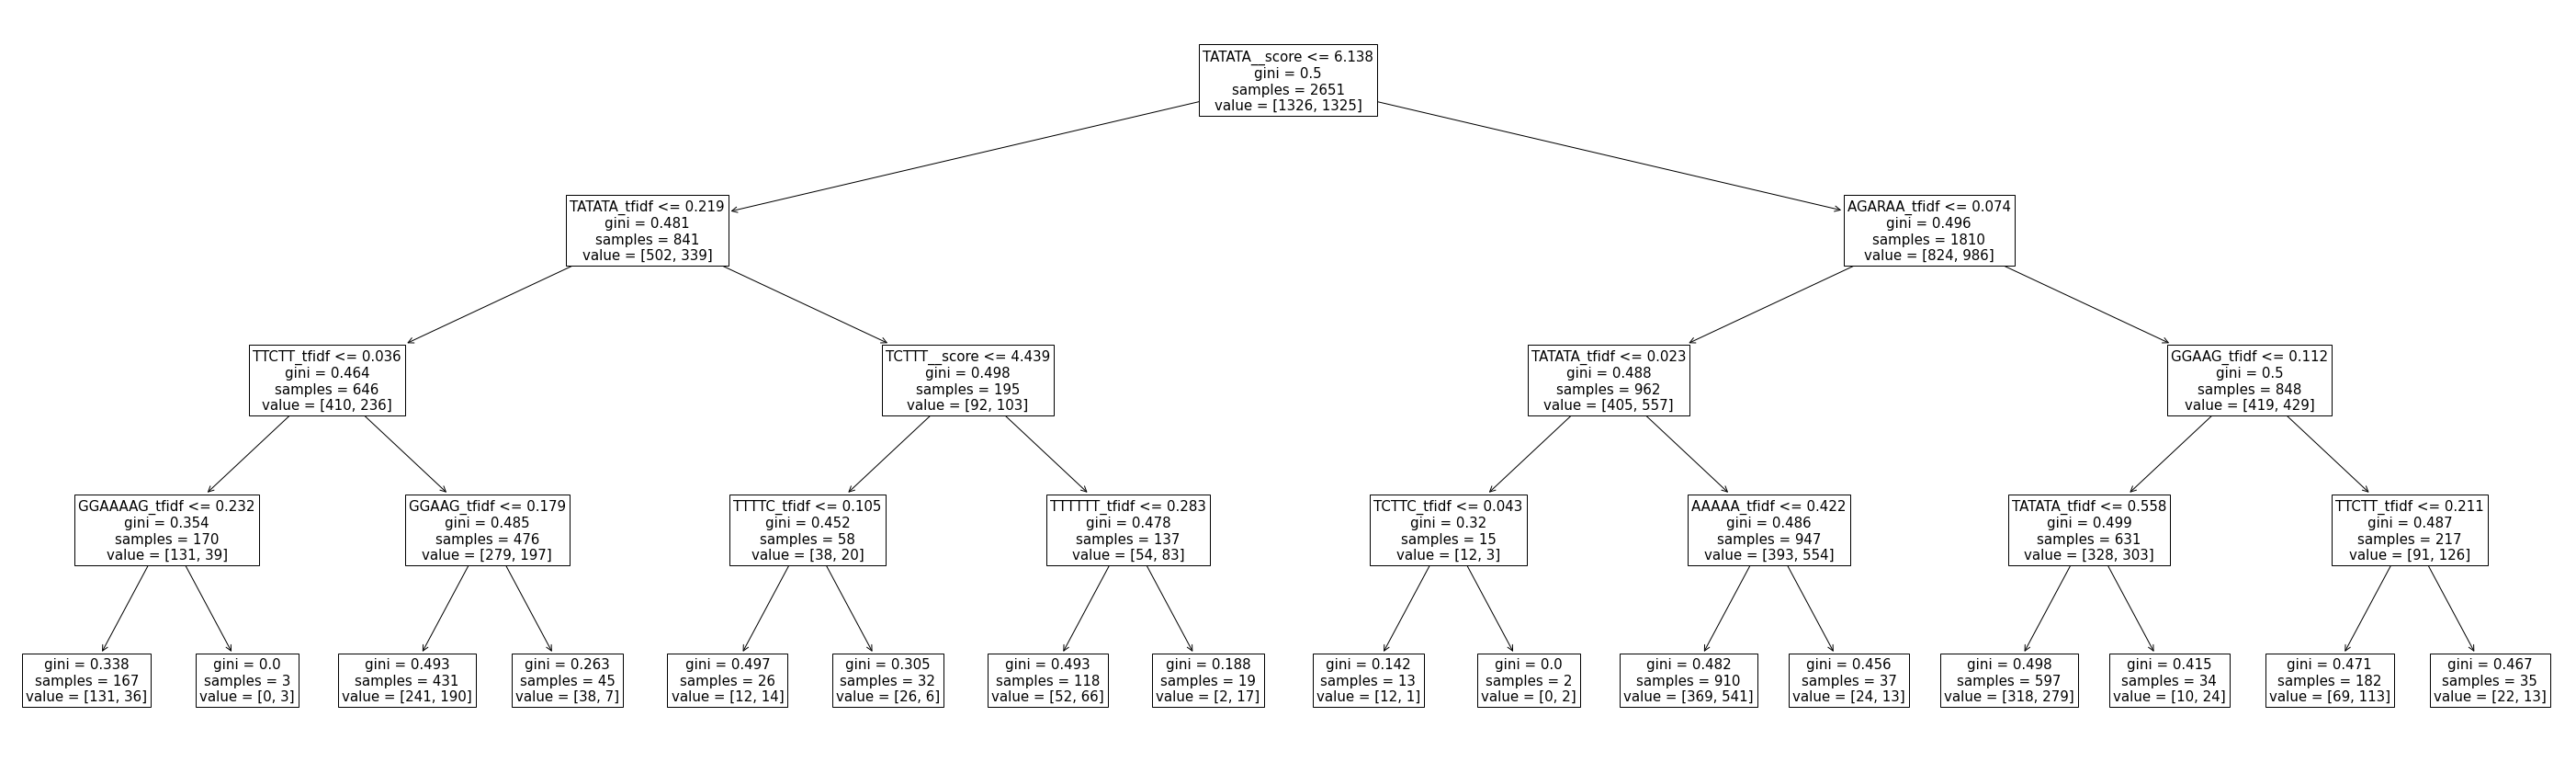

In [51]:

from sklearn.tree import DecisionTreeClassifier
t = DecisionTreeClassifier(random_state=123456, max_depth=4)
t.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
predicted = t.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Mean accuracy score: {accuracy:.3}')
from sklearn.tree import plot_tree
fig,ax=plt.subplots(1,1, figsize=(50,15))
_ = plot_tree(t,feature_names=features,ax=ax,fontsize=15)

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)

In [53]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.541
Mean accuracy score: 1.0


In [54]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.541
Mean accuracy score: 0.539


<AxesSubplot:>

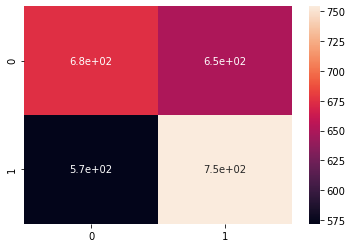

In [55]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=range(2), index=range(2))
sns.heatmap(cm, annot=True)

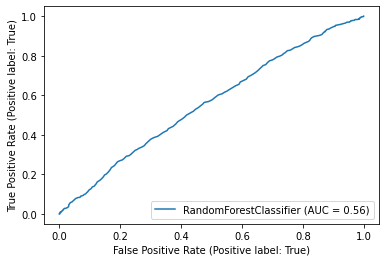

In [56]:
from sklearn.metrics import RocCurveDisplay
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

### Regression (RF)

[Source](https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/)

In [57]:
df_subset.shape

(5302, 63)

In [58]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df_subset.loc[:,features], df_subset.int_group, train_size=0.8, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [59]:
from sklearn.metrics import mean_squared_error as mse

In [60]:
np.sqrt(np.sum((y_train - np.mean(y_train))**2)/len(y_train))

2.88249164597269

Mean squared score: 7.51


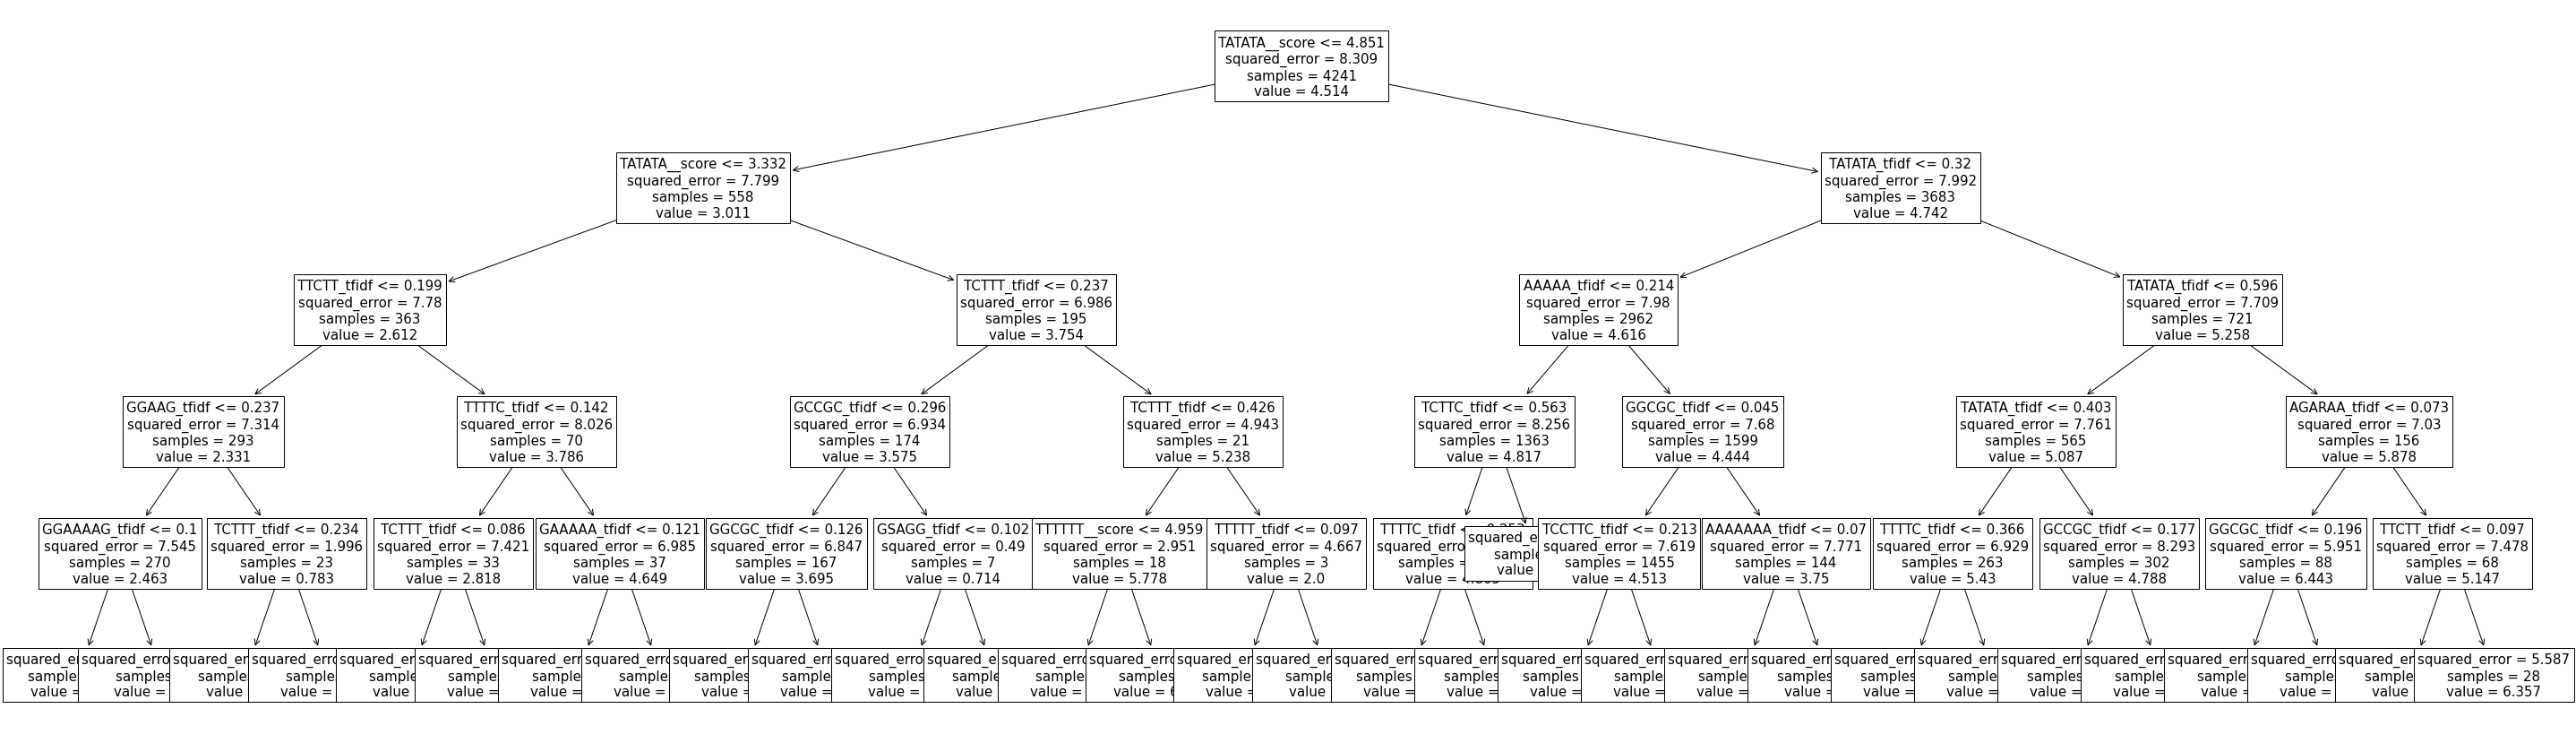

In [61]:
from sklearn.tree import DecisionTreeRegressor
t = DecisionTreeRegressor(random_state=123456, max_depth=5)
t.fit(X_train, y_train)
predicted = t.predict(X_train)
m = mse(y_train, predicted)
print(f'Mean squared score: {m:.3}')
from sklearn.tree import plot_tree
fig,ax=plt.subplots(1,1, figsize=(50,15))
_ = plot_tree(t,feature_names=features,ax=ax,fontsize=15)

In [62]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=0)

In [63]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate:  0.02
Test data R-2 score: 0.00831
Test data Spearman correlation: 0.144
Test data Pearson correlation: 0.159


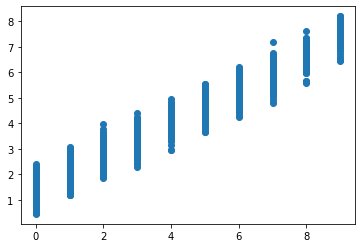

In [64]:
plt.scatter(y_train, predicted_train)

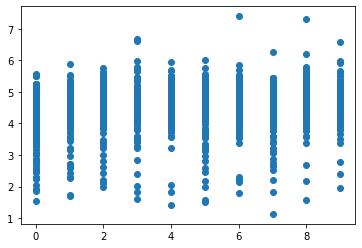

In [65]:
plt.scatter(y_test, predicted_test)

In [66]:
from umap.umap_ import UMAP

In [67]:
mapper = UMAP().fit(df_temp[features])

<AxesSubplot:>

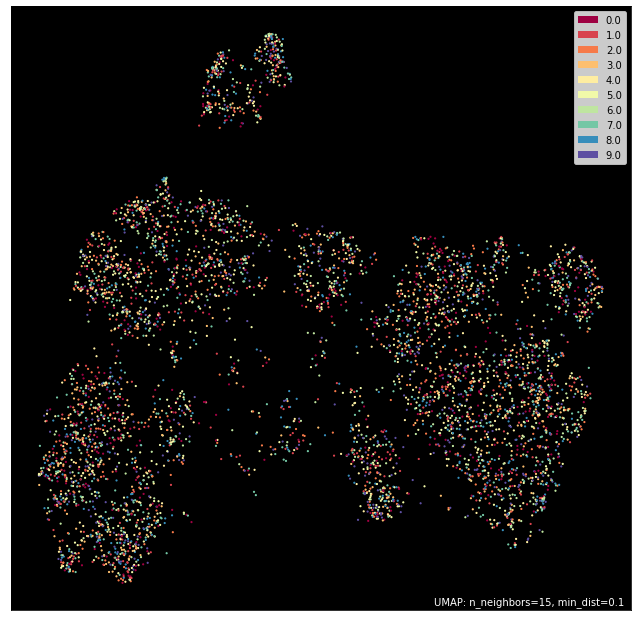

In [68]:
import umap.plot  # pip install umap-learn[plot]

umap.plot.points(mapper, labels=featDf['int_group'], theme="viridis")

In [69]:
counts.shape

(5302, 36)

In [70]:
len(raw_columns)

72

In [71]:
a = [str(m.degenerate_consensus) for m in motifs]
_, p = np.unique(a, return_index=True)
uni_cols = np.array([str(m.degenerate_consensus) for m in motifs])[p].tolist()

In [72]:
countsDf = pd.DataFrame(counts[:, p], columns= uni_cols)
countsDf['intensity'] = df['intensity']

In [73]:
tfidfDf = countsDf.copy()
tfidfDf[:] = TfidfTransformer().fit_transform(countsDf).todense()
tfidfDf['intensity'] = df['intensity']

<AxesSubplot:>

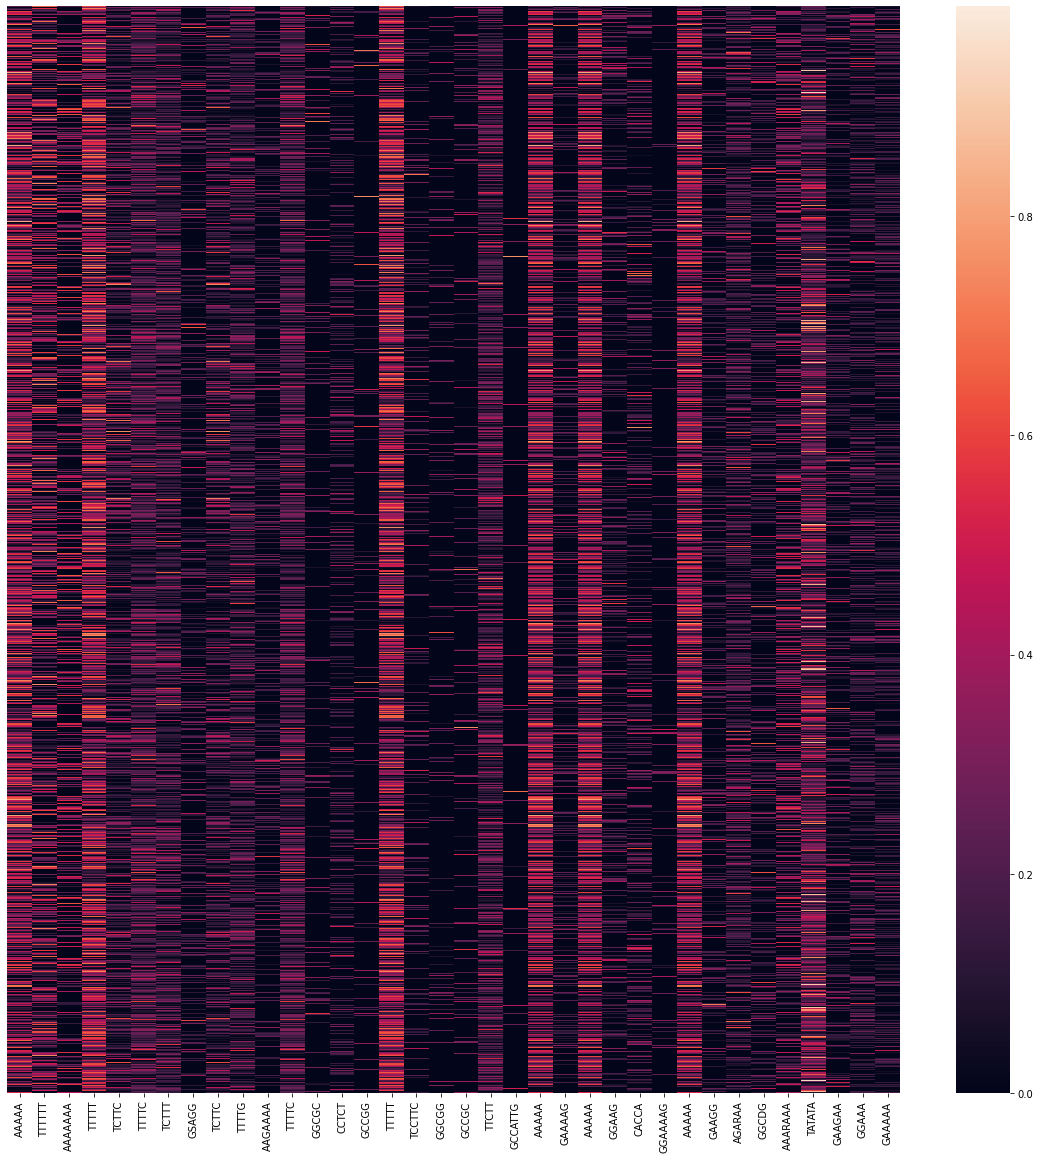

In [74]:
plt.figure(figsize=(20,20))
sns.heatmap(tfidfDf.sort_values('intensity')[a],yticklabels=False)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



<Figure size 1440x1440 with 0 Axes>

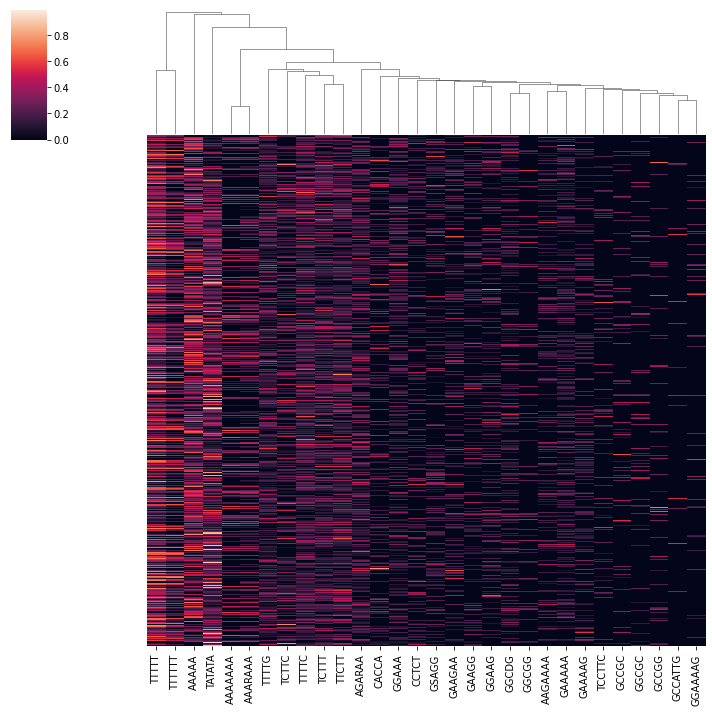

In [75]:
plt.figure(figsize=(20,20))
sns.clustermap(tfidfDf.sort_values('intensity')[uni_cols],yticklabels=False,row_cluster=False)

In [76]:
motifs_s

{0: ['AAAAA', 'TTTTTT', 'AAAAAAA'],
 1: [],
 2: ['TTTTT', 'TCTTC'],
 3: [],
 4: ['TTTTC', 'TCTTT', 'GSAGG', 'TCTTC', 'TTTTG', 'AAGAAAA'],
 5: ['TTTTC',
  'GGCGC',
  'CCTCT',
  'GCCGG',
  'TTTTT',
  'TCCTTC',
  'GGCGG',
  'GCCGC',
  'TTCTT',
  'GCCATTG'],
 6: ['AAAAA', 'GAAAAG'],
 7: ['AAAAA', 'GGAAG', 'CACCA', 'GGAAAAG'],
 8: [],
 9: ['AAAAA', 'GAAGG', 'AGARAA', 'GGCDG'],
 10: ['AAARAAA', 'TATATA', 'GAAGAA', 'GGAAA', 'GAAAAA']}

### Try only with last motifs group and using groups 0 and 9

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
subset_feats = ([x + '__score' for x in motifs_s[10]] +
                       [x + '_tfidf' for x in motifs_s[10]])

df_subset = featDf.loc[featDf['int_group'].isin([0,9]), subset_feats + ['int_group']
                       ].copy()
df_subset['int_bool'] = df_subset.int_group.astype(float) >= 5
X_train, X_test, y_train, y_test = train_test_split(df_subset.loc[:,subset_feats], df_subset.int_bool, test_size=0.5,
                                                    stratify=df_subset.int_bool, random_state=123456)
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy train score: {accuracy:.3}')
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy test score: {accuracy:.3}')

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Out-of-bag score estimate: 0.646
Mean accuracy train score: 0.996
Mean accuracy test score: 0.608
